In [36]:
!pip install -q tensorflow==2.13.0 numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.4

In [37]:
!pip show keras tensorflow numpy scikit-learn matplotlib | grep -o 'Version:.*' | awk '{print $2}'

2.13.1
2.13.0
1.24.3
1.2.2
3.7.4


In [38]:
import os
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
IMAGE_SIZE = (128, 32)
BATCH_SIZE = 64
EPOCHS = 50
PADDING_TOKEN = 99

In [1]:
# References https://www.kaggle.com/code/hamiddamadi/handwritten-text-recognition-iam

### Preprocessing the Handwritten Text Dataset

This preprocessed data, including the image paths, labels, character mapping, and maximum sequence length, will be used for subsequent steps like loading images, preparing sequences, and building the HTR model.

Dataset is held within 'iam_words' folder, this folder holds words.txt file that contains labels for the image files in 'words' folder.

In [40]:
DATA_INPUT_PATH = "/kaggle/input/iam-handwriting-word-database"

images_path = []
labels = []

def preprocess_dataset():
    characters = set()
    max_len = 0
    with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
        lines = file.readlines()

        for line_number, line in enumerate(lines):
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Split the line and extract information
            parts = line.strip().split()

            # Continue with the rest of the code
            word_id = parts[0]

            first_folder = word_id.split("-")[0]
            second_folder = first_folder + '-' + word_id.split("-")[1]

            # Construct the image filename
            image_filename = f"{word_id}.png"
            image_path = os.path.join(
                DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            # Check if the image file exists
            if os.path.isfile(image_path) and os.path.getsize(image_path):

                images_path.append(image_path)

                # Extract labels
                label = parts[-1].strip()
                for char in label:
                    characters.add(char)

                max_len = max(max_len, len(label))
                labels.append(label)

    characters = sorted(list(characters))

    print('characters: ', characters)
    print('max_len: ', max_len)
    # Mapping characters to integers.
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=list(characters), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = tf.keras.layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return characters, char_to_num, num_to_char, max_len
    
characters, char_to_num, num_to_char, max_len = preprocess_dataset()

characters:  ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len:  19


In [41]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(
        label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]],
                   constant_values=PADDING_TOKEN)
    return label

In [42]:
def process_images_labels(image_path, label):
    image = preprocess_image(image_path, IMAGE_SIZE)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    AUTOTUNE = tf.data.AUTOTUNE
    print('len(image_paths): ', len(image_paths))
    print('len(labels): ', len(labels))
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [43]:
def split_dataset():
    # Split the data into training, validation, and test sets using train_test_split
    train_images, test_images, train_labels, test_labels = train_test_split(
        images_path, labels, test_size=0.2, random_state=42
    )

    # Further split the test set into validation and final test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=42
    )

    train_set = prepare_dataset(train_images, train_labels)
    val_set = prepare_dataset(val_images, val_labels)
    test_set = prepare_dataset(test_images, test_labels)
    
    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset()

len(image_paths):  35650
len(labels):  35650
len(image_paths):  4456
len(labels):  4456
len(image_paths):  4457
len(labels):  4457


## Building the Handwritten Text Recognition Model (HTR)

### Custom CTC Layer

This code defines a custom layer named `CTCLayer` that inherits from `tf.keras.layers.Layer`. This layer is specifically designed for handling the Connectionist Temporal Classification (CTC) loss function commonly used in sequence recognition tasks like handwritten text recognition (HTR).

**Call method:**

* This method defines the forward pass of the layer, taking the ground truth labels (`y_true`) and model predictions (`y_pred`) as input.
* It performs the following steps:
    * **Calculate shapes:** Extracts relevant dimensions from the input shapes:
        * Batch size (`batch_len`) from the number of samples in the ground truth labels.
        * Predicted sequence length (`input_length`) from the shape of the predictions.
        * Ground truth label length (`label_length`) from the shape of the labels.
    * **Reshape lengths:** Reshapes the sequence lengths to have a batch dimension (size of batch x 1) for compatibility with the CTC loss function.
    * **Calculate loss:** Calculates the CTC loss using the internal `loss_fn` and adds it to the model's total loss using `self.add_loss`.
    * **Return predictions:** During testing (when `y_true` is None), the layer simply returns the predictions without calculating the loss.


By incorporating this layer into the model, we can effectively train the HTR model using the CTC loss function, enabling it to learn to recognize handwritten text sequences.

In [44]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * \
            tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * \
            tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

## Candidate Model #1: CNN ONLY ARCHITECTURE

In [45]:
def build_model():
    input_img = tf.keras.Input(
        shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.summary()
    return model
    
model = build_model()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 64, 16, 32)           0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 16, 64)           18496     ['max_pooling2d_2[0][0]'

### Edit Distance Callback Class

By incorporating this callback during training, we can monitor the model's progress beyond just the training and validation losses, providing a more comprehensive understanding of its performance on unseen data.

In [46]:
class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model, max_len, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.max_len = max_len
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def calculate_edit_distance(self, labels, predictions, max_len):
        # Get a single batch and convert its labels to sparse tensors.
        saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

        # Make predictions and convert them to sparse tensors.
        input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
        predictions_decoded = tf.keras.backend.ctc_decode(
            predictions, input_length=input_len, greedy=True
        )[0][0][:, :max_len]
        sparse_predictions = tf.cast(
            tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
        )

        # Compute individual edit distances and average them out.
        edit_distances = tf.edit_distance(
            sparse_predictions, saprse_labels, normalize=False
        )
        return tf.reduce_mean(edit_distances)

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            predictions = self.prediction_model.predict(
                self.validation_images[i])
            edit_distances.append(self.calculate_edit_distance(
                labels, predictions, self.max_len).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

## Training the Handwritten Text Recognition (HTR) Model


**Callbacks:**

* **EditDistanceCallback:** 
    * An instance of the custom `EditDistanceCallback` class is created, providing the prediction model, maximum label length, validation images, and labels.
    * This callback monitors the edit distance on the validation set during training.
* **EarlyStopping:** 
    * A standard `EarlyStopping` callback is instantiated to monitor validation loss and stop training if it doesn't improve for 10 epochs, restoring the best weights found so far.

In [47]:
def train_model(model, epochs):

    validation_images = []
    validation_labels = []

    for batch in val_set:
        validation_images.append(batch["image"])
        validation_labels.append(batch["label"])

    prediction_model = tf.keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(
            name="dense2").output
    )
    edit_distance_callback = EditDistanceCallback(
        prediction_model, max_len, validation_images, validation_labels)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Train the model.
    hist = model.fit(
        train_set,
        validation_data=val_set,
        epochs=epochs,
        callbacks=[edit_distance_callback, early_stopping],
    )
    return hist, prediction_model

history, prediction_model = train_model(model, 50)

Epoch 1/50
2/2 [==============================] - 0s 7ms/step
Mean edit distance for epoch 1: 19.0000
558/558 [==============================] - 102s 180ms/step - loss: 18.7265 - val_loss: 14.4851
Epoch 2/50
2/2 [==============================] - 0s 8ms/step
Mean edit distance for epoch 2: 18.9423
558/558 [==============================] - 86s 154ms/step - loss: 14.1051 - val_loss: 13.6029
Epoch 3/50
2/2 [==============================] - 0s 8ms/step
Mean edit distance for epoch 3: 18.8454
558/558 [==============================] - 87s 155ms/step - loss: 13.3940 - val_loss: 12.8485
Epoch 4/50
2/2 [==============================] - 0s 8ms/step
Mean edit distance for epoch 4: 18.8032
558/558 [==============================] - 87s 155ms/step - loss: 12.8268 - val_loss: 12.3253
Epoch 5/50
2/2 [==============================] - 0s 8ms/step
Mean edit distance for epoch 5: 18.7471
558/558 [==============================] - 89s 159ms/step - loss: 12.3073 - val_loss: 11.8061
Epoch 6/50
2/2 [===

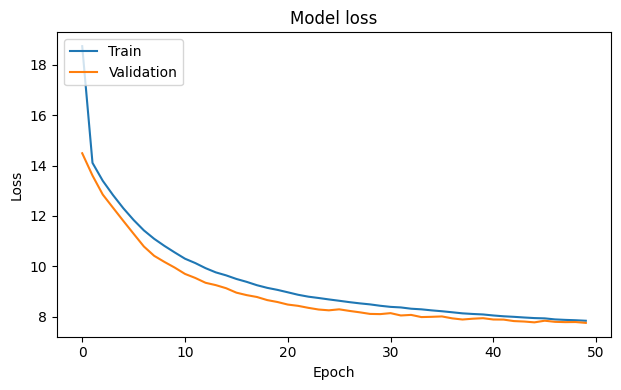

In [48]:
def visualize_train_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_train_history(history)

## EVALUATING CNN ONLY MODEL

In [49]:
def evaluate_model():
    loss = model.evaluate(test_set)
    print("Test Loss:", loss)
evaluate_model() 

70/70 [==============================] - 4s 61ms/step - loss: 7.6606
Test Loss: 7.660633087158203


## Inference on Test Set

In [50]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]

    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

2/2 [==============================] - 0s 18ms/step


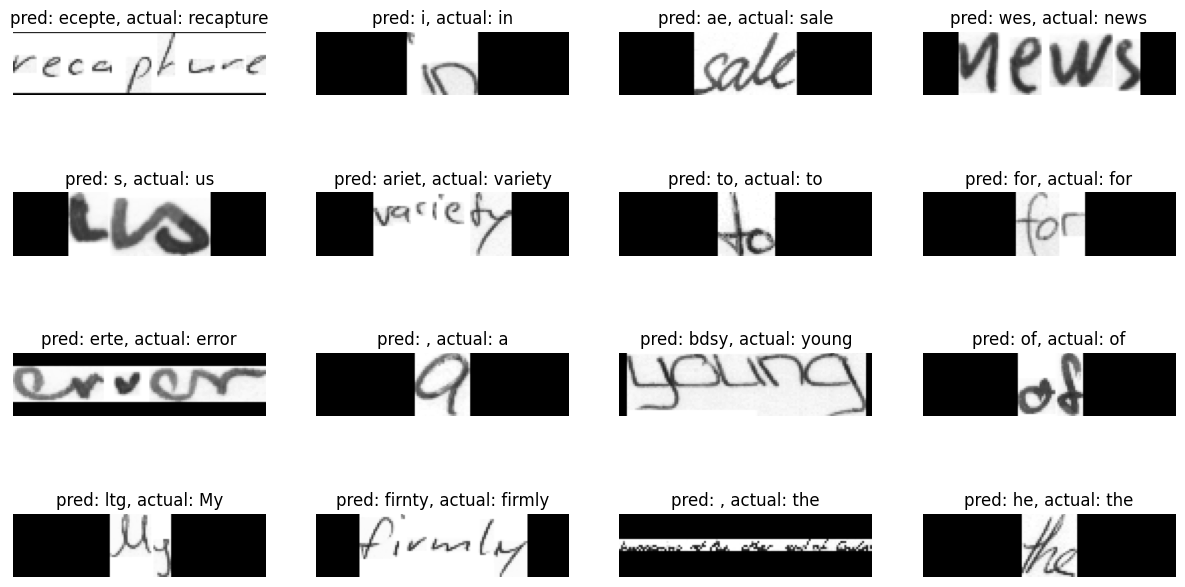

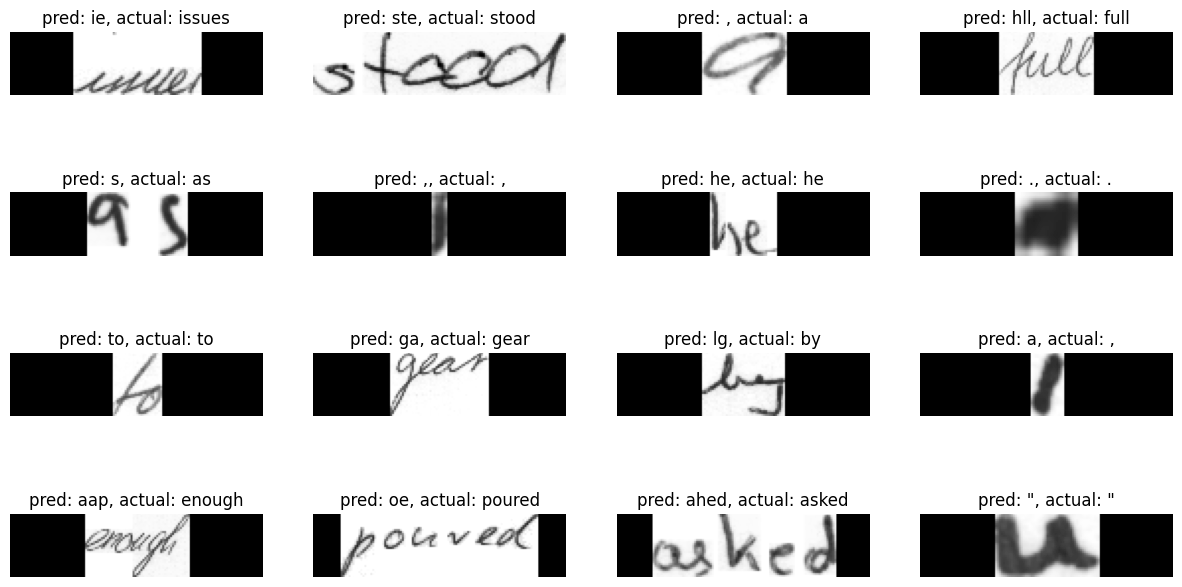

In [51]:
def get_sample_predictions(prediction_model):
    for batch in test_set.take(2):
        batch_images = batch["image"]
        batch_labels = batch["label"]
        _, ax = plt.subplots(4, 4, figsize=(15, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

             # Gather indices where label!= padding_token.
            label = batch_labels[i]
            indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
            # Convert to string.
            label = tf.strings.reduce_join(num_to_char(indices))
            label = label.numpy().decode("utf-8")

            title = f"pred: {pred_texts[i]}, actual: {label}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")

    plt.show()

get_sample_predictions(prediction_model)

### CER average per prediction for entire test set. 

In [52]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def character_error_rate(ref, hyp):
    ref = ref.lower().strip()
    hyp = hyp.lower().strip()
    distance = levenshtein_distance(ref, hyp)
    distance / len(ref)
    return [distance, len(ref)]

# # Example usage:
# reference = "hello world"
# hypothesis = "helloo wrld"
# cer = character_error_rate(reference, hypothesis)
# print("Character Error Rate:", cer)

In [53]:
def get_cer(prediction_model):
    total_samples = 4457
    batch_sizes = 64
    total_batches = (total_samples + batch_sizes - 1) // batch_sizes

    fixed_cer_by_word = []
    for batch in test_set.take(total_batches):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(min(len(batch_labels),64)):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

             # Gather indices where label!= padding_token.
            label = batch_labels[i]
            indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
            # Convert to string.
            label = tf.strings.reduce_join(num_to_char(indices))
            label = label.numpy().decode("utf-8")

            #print([pred_texts[i], label])

            cer = character_error_rate(label, pred_texts[i])

            fixed_cer_by_word.append(cer[0]/cer[1])

    print("Test Set CER average per prediction:", np.mean(fixed_cer_by_word))
    
get_cer(prediction_model)

2/2 [==============================] - 0s 8ms/step
Test Set CER average per prediction: 0.5227717608719403


### Letter Accuracy: How many letters predicted right out of all letters

In [54]:
def get_letter_accuracy(prediction_model):
    total_samples = 4457
    batch_sizes = 64
    total_batches = (total_samples + batch_sizes - 1) // batch_sizes

    num_c_wrong = []
    num_c_total = []
    for batch in test_set.take(total_batches):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(min(len(batch_labels),64)):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

             # Gather indices where label!= padding_token.
            label = batch_labels[i]
            indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
            # Convert to string.
            label = tf.strings.reduce_join(num_to_char(indices))
            label = label.numpy().decode("utf-8")

            #print([pred_texts[i], label])

            cer = character_error_rate(label, pred_texts[i])
            num_c_wrong.append(cer[0])
            num_c_total.append(cer[1])

    print("Test Set Letter Accuracy:", 1-(sum(num_c_wrong)/sum(num_c_total)))

get_letter_accuracy(prediction_model)

2/2 [==============================] - 0s 9ms/step
Test Set Letter Accuracy: 0.4604115049014327


### Word Accuracy for Entire Test set.

In [55]:
def get_word_accuracy(prediction_model):
    total_samples = 4457
    batch_sizes = 64
    total_batches = (total_samples + batch_sizes - 1) // batch_sizes

    grades = []
    for batch in test_set.take(total_batches):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(min(len(batch_labels),64)):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

             # Gather indices where label!= padding_token.
            label = batch_labels[i]
            indices = tf.gather(label, tf.where(tf.math.not_equal(label, PADDING_TOKEN)))
            # Convert to string.
            label = tf.strings.reduce_join(num_to_char(indices))
            label = label.numpy().decode("utf-8")
            if label == pred_texts[i]:
                grade = 1
            elif label != pred_texts[i]:
                grade = 0
            grades.append(grade)
    print("Test set word accuracy:", sum(grades)/len(grades))
    print("Test set word error rate:", 1-(sum(grades)/len(grades)))

get_word_accuracy(prediction_model)

2/2 [==============================] - 0s 8ms/step
Test set word accuracy: 0.1702939196769127
Test set word error rate: 0.8297060803230873


## Candidate Model #2: CNN-RNN(LSTM) ARCHITECTURE

In [56]:
def build_model():
    input_img = tf.keras.Input(
        shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.summary()
    return model
    
model = build_model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 16, 32)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 64, 16, 64)           18496     ['max_pooling2d_4[0][0]'

In [57]:
history, prediction_model = train_model(model, 80)

Epoch 1/80
2/2 [==============================] - 1s 15ms/step
Mean edit distance for epoch 1: 18.8142
558/558 [==============================] - 158s 269ms/step - loss: 15.4553 - val_loss: 13.4870
Epoch 2/80
2/2 [==============================] - 0s 16ms/step
Mean edit distance for epoch 2: 18.5138
558/558 [==============================] - 143s 257ms/step - loss: 13.0122 - val_loss: 12.4259
Epoch 3/80
2/2 [==============================] - 0s 18ms/step
Mean edit distance for epoch 3: 18.3553
558/558 [==============================] - 146s 261ms/step - loss: 11.9427 - val_loss: 11.1613
Epoch 4/80
2/2 [==============================] - 0s 18ms/step
Mean edit distance for epoch 4: 18.1815
558/558 [==============================] - 143s 257ms/step - loss: 10.9133 - val_loss: 10.4538
Epoch 5/80
2/2 [==============================] - 0s 15ms/step
Mean edit distance for epoch 5: 18.0096
558/558 [==============================] - 144s 258ms/step - loss: 10.1442 - val_loss: 9.5095
Epoch 6/80


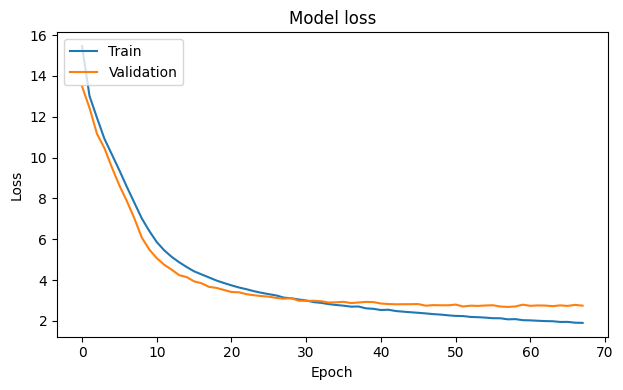

In [58]:
visualize_train_history(history)

## OPTIONAL: HOW TO SAVE AND LOAD TRAINED MODEL 

#### EXAMPLE for CNN-RNN(LSTM) Architecture Trained Model (80 epochs)

In [59]:
# saves model to local directory with updated final weights and architecture
# model.save('htr-cnn-lstm-80epochs_v2.keras')

In [60]:
# # LOAD MODEL FROM TRAINED MODEL.KERAS FILE SAVED IN LOCAL DIR
# # ALTERNATIVELY LOAD MODEL FILE FROM KAGGLE AVAILABLE MODELS
# from tensorflow.keras.models import load_model
# custom_objects = {'CTCLayer': CTCLayer}


# model = load_model('/kaggle/input/h2tr-cnn-lstm-80epochs/tensorflow2/v2/1/htr-cnn-lstm-80epochs_v2.keras', 
#                    custom_objects=custom_objects)

# prediction_model = tf.keras.models.Model(
#         model.get_layer(name="image").input, model.get_layer(
#             name="dense2").output)

## EVALUATING CNN-RNN(LSTM) MODEL

In [61]:
def evaluate_model():
    loss = model.evaluate(test_set)
    print("Test Loss:", loss)
evaluate_model() 

70/70 [==============================] - 5s 72ms/step - loss: 2.7227
Test Loss: 2.7227413654327393


## Inference on Test Set

2/2 [==============================] - 0s 43ms/step


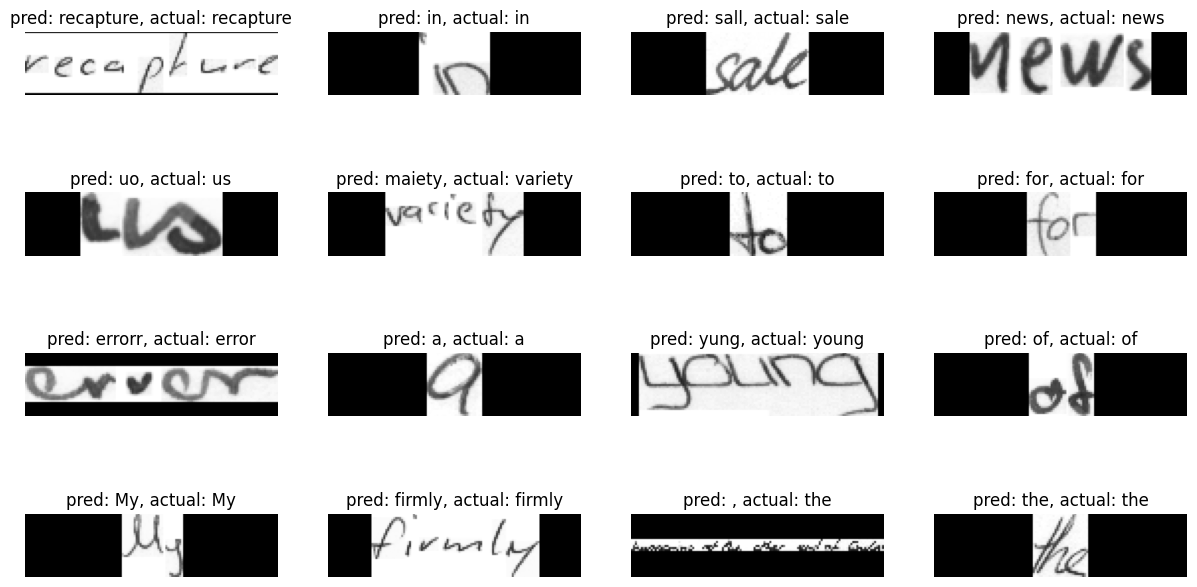

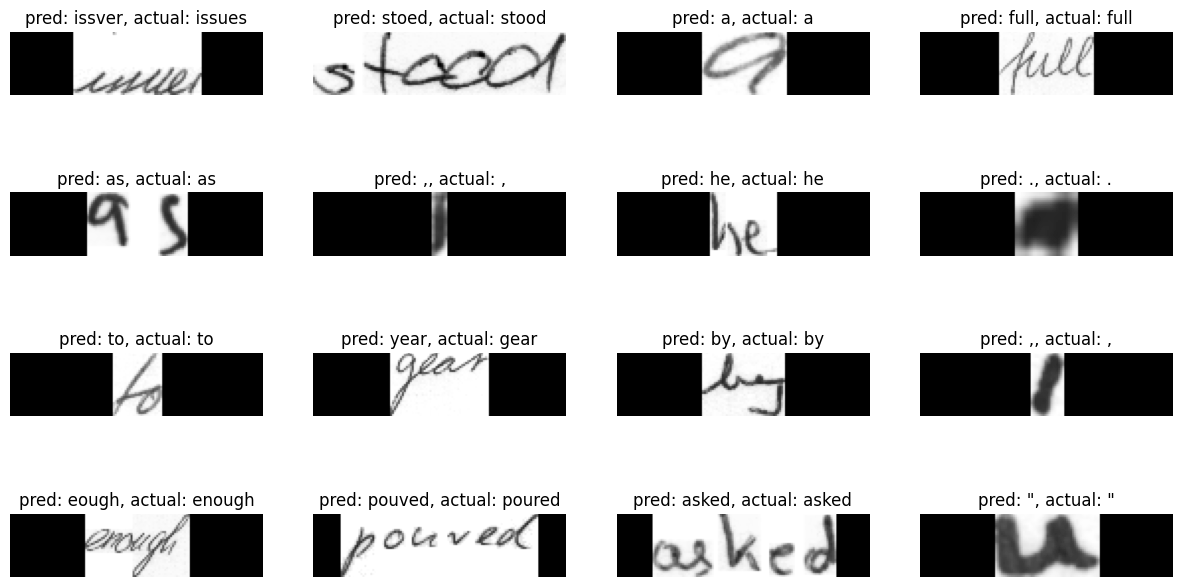

In [62]:
get_sample_predictions(prediction_model)

### CER average per prediction for entire test set.

In [63]:
get_cer(prediction_model)

2/2 [==============================] - 0s 19ms/step
Test Set CER average per prediction: 0.14603969311171464


### Letter Accuracy: How many letters predicted right out of all letters

In [ ]:
get_letter_accuracy(prediction_model)

2/2 [==============================] - 0s 16ms/step
Test Set Letter Accuracy: 0.8420769147904772


### Word Accuracy for Entire Test set.

In [ ]:
get_word_accuracy(prediction_model)

2/2 [==============================] - 0s 15ms/step
Test set word accuracy: 0.6515593448507965
Test set word error rate: 0.3484406551492035
